In [1]:
# Import the libraries
import numpy as np
import os

# Deep learning
import keras
from keras.models import Model
from keras.layers import (
    Input,
    Dense,
    Conv2D,
    Dropout,
    BatchNormalization,
    Flatten,
    Activation,
    Reshape,
    Conv2DTranspose,
    UpSampling2D,
)
from keras.optimizers import RMSprop

# For plotting
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
# Importing the dataset
input_images = "./quickdraw_data/apple.npy"
data = np.load(input_images)

In [3]:
data.shape

(144722, 784)

In [4]:
data[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,  11,  21,  12,   0,   0,   0,   0,   0,   0,   0,
         0,  92,  20,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,  91, 213, 253, 255, 255, 222,  95,   3,   0,   0,
         0,   0,   7, 255, 222,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,  24, 190, 255, 196, 118, 100, 109, 196, 255, 121,
         0,   0,   0,   0,   0, 141,  35,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   1, 185, 241,  94,   1,   0,   0,   0,   0,
        63,  25,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,  89, 255, 115, 133, 150,  37,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0, 207, 241, 252, 25

In [5]:
data.shape

(144722, 784)

In [6]:
# Preprocessing
data = data / 255
data = np.reshape(data, (data.shape[0], 28, 28, 1))
img_w, img_h = data.shape[1:3]

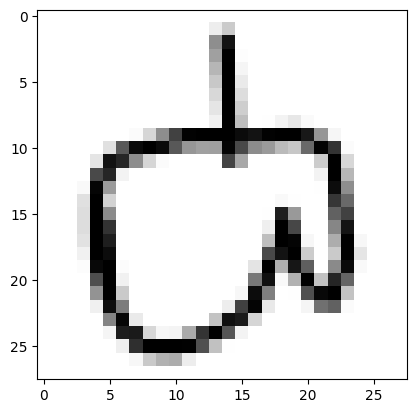

In [7]:
# Plot data
plt.imshow(data[4242, :, :], cmap="Greys")

In [9]:
# Discriminator Netowork
def build_discriminator(depth=64, p=0.4):
    # Define image
    image = Input((img_w, img_h, 1))

    # Convolution layer
    # 1st layer
    conv1 = Conv2D(
        depth * 1, kernel_size=5, strides=2, padding="same", activation="relu"
    )(image)
    conv1 = Dropout(p)(conv1)

    # 2nd Layer
    conv2 = Conv2D(
        depth * 2, kernel_size=5, strides=2, padding="same", activation="relu"
    )(conv1)
    conv2 = Dropout(p)(conv2)

    # 3rd Layer
    conv3 = Conv2D(
        depth * 4, kernel_size=5, strides=2, padding="same", activation="relu"
    )(conv2)
    conv3 = Dropout(p)(conv3)

    # 4th Layer
    conv4 = Conv2D(
        depth * 8, kernel_size=5, strides=1, padding="same", activation="relu"
    )(conv2)
    conv4 = Flatten()(Dropout(p)(conv4))

    # Output layer
    prediction = Dense(1, activation="sigmoid")(conv4)

    # Model definition
    model = Model(inputs=image, outputs=prediction)

    return model

In [10]:
discriminator = build_discriminator()
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 512)         1638912   
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 512)         0     

In [13]:
# Compile model
discriminator.compile(
    loss="binary_crossentropy",
    optimizer=RMSprop(lr=0.0008, rho=6e-8, clipvalue=1.0),
    metrics=["accuracy"],
)

In [14]:
# Generator model
z_dimensions = 32


def build_generator(latent_dim=z_dimensions, depth=64, p=0.4):
    # Define Inputs
    noise = Input((latent_dim,))

    # First dense layer
    dense1 = Dense(7 * 7 * depth)(noise)
    dense1 = BatchNormalization(momentum=0.9)(dense1)
    dense1 = Activation(activation="relu")(dense1)
    dense1 = Reshape((7, 7, depth))(dense1)
    dense1 = Dropout(p)(dense1)

    # De-Convolutional layers
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(
        int(depth / 2),
        kernel_size=5,
        padding="same",
        activation=None,
    )(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation="relu")(conv1)

    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(
        int(depth / 4),
        kernel_size=5,
        padding="same",
        activation=None,
    )(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation="relu")(conv2)

    conv3 = Conv2DTranspose(
        int(depth / 8),
        kernel_size=5,
        padding="same",
        activation=None,
    )(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation="relu")(conv3)

    # Output layer
    image = Conv2D(1, kernel_size=5, padding="same", activation="sigmoid")(conv3)

    # Model definition
    model = Model(inputs=noise, outputs=image)

    return model

In [15]:
generator = build_generator()

In [16]:
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_1 (Dense)             (None, 3136)              103488    
                                                                 
 batch_normalization (Batch  (None, 3136)              12544     
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 3136)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 64)          0         
                                                           

## Create adversial network

In [17]:
z = Input(shape=(z_dimensions,))
img = generator(z)

In [18]:
discriminator.trainable = False

In [19]:
pred = discriminator(img)

In [22]:
adversarial_model = Model(z, pred)

In [23]:
adversarial_model.compile(
    loss="binary_crossentropy",
    optimizer=RMSprop(lr=0.0004, rho=3e-8, clipvalue=1.0),
    metrics=["accuracy"],
)

In [24]:
# Train
def train(epochs=2000, batch=128, z_dim=z_dimensions):
    d_metrics = []
    a_metrics = []

    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0

    for i in range(epochs):
        # sample real images:
        real_imgs = np.reshape(
            data[np.random.choice(data.shape[0], batch, replace=False)],
            (batch, 28, 28, 1),
        )

        # generate fake images:
        fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, z_dim]))

        # concatenate images as discriminator inputs:
        x = np.concatenate((real_imgs, fake_imgs))

        # assign y labels for discriminator:
        y = np.ones([2 * batch, 1])
        y[batch:, :] = 0

        # train discriminator:
        d_metrics.append(discriminator.train_on_batch(x, y))
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]

        # adversarial net's noise input and "real" y:
        noise = np.random.uniform(-1.0, 1.0, size=[batch, z_dim])
        y = np.ones([batch, 1])

        # train adversarial net:
        a_metrics.append(adversarial_model.train_on_batch(noise, y))
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]

        # periodically print progress & fake images:
        if (i + 1) % 100 == 0:
            print("Epoch #{}".format(i))
            log_mesg = "%d: [D loss: %f, acc: %f]" % (
                i,
                running_d_loss / i,
                running_d_acc / i,
            )
            log_mesg = "%s  [A loss: %f, acc: %f]" % (
                log_mesg,
                running_a_loss / i,
                running_a_acc / i,
            )
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, size=[16, z_dim])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5, 5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k + 1)
                plt.imshow(gen_imgs[k, :, :, 0], cmap="gray")
                plt.axis("off")

            plt.tight_layout()
            plt.show()

    return a_metrics, d_metrics

4/4 [==============================] - 0s 14ms/step
Epoch #99
99: [D loss: 1.046567, acc: 0.778251]  [A loss: 2.131686, acc: 0.509312]
1/1 [==============================] - 0s 89ms/step


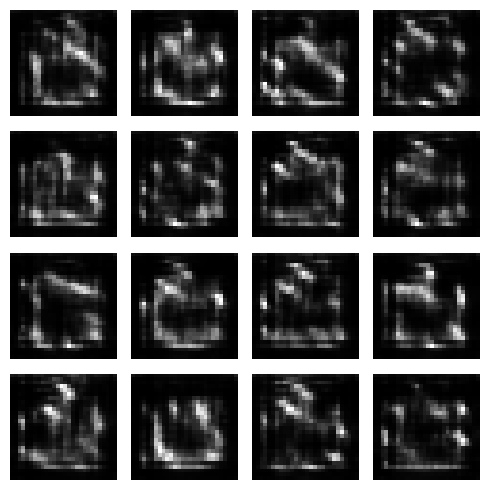

4/4 [==============================] - 0s 15ms/step
Epoch #199
199: [D loss: 0.847440, acc: 0.690601]  [A loss: 1.687190, acc: 0.486613]
1/1 [==============================] - 0s 20ms/step


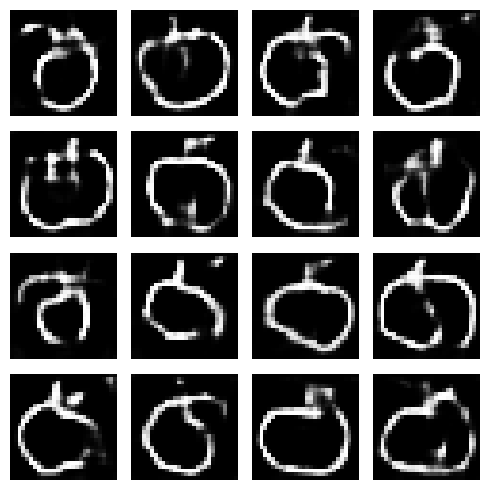

4/4 [==============================] - 0s 16ms/step
Epoch #299
299: [D loss: 0.781864, acc: 0.648673]  [A loss: 1.432259, acc: 0.446932]
1/1 [==============================] - 0s 20ms/step


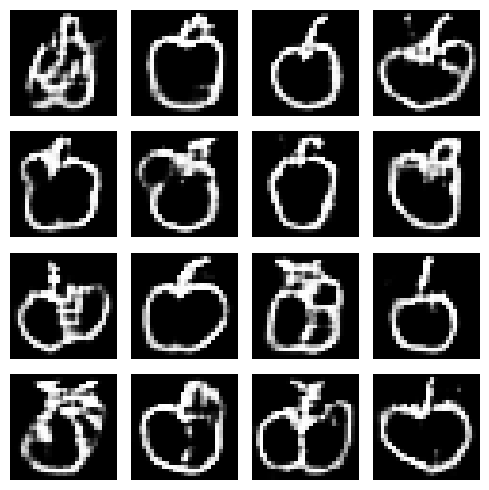

4/4 [==============================] - 0s 13ms/step
Epoch #399
399: [D loss: 0.749105, acc: 0.632764]  [A loss: 1.319594, acc: 0.416941]
1/1 [==============================] - 0s 19ms/step


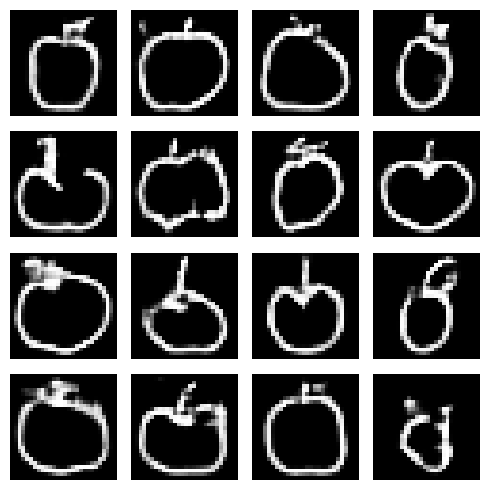

4/4 [==============================] - 0s 13ms/step
Epoch #499
499: [D loss: 0.731144, acc: 0.620507]  [A loss: 1.245612, acc: 0.404543]
1/1 [==============================] - 0s 17ms/step


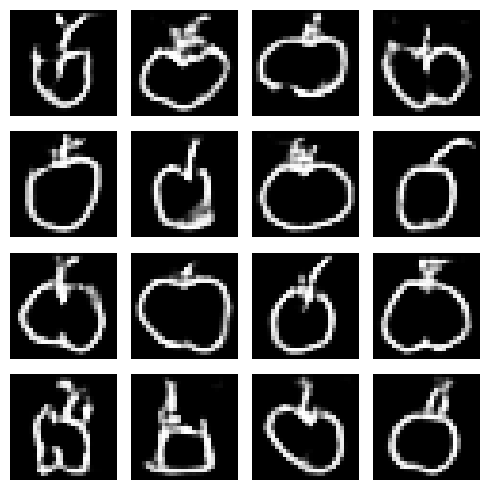

4/4 [==============================] - 0s 13ms/step
Epoch #599
599: [D loss: 0.717187, acc: 0.614703]  [A loss: 1.199824, acc: 0.395868]
1/1 [==============================] - 0s 18ms/step


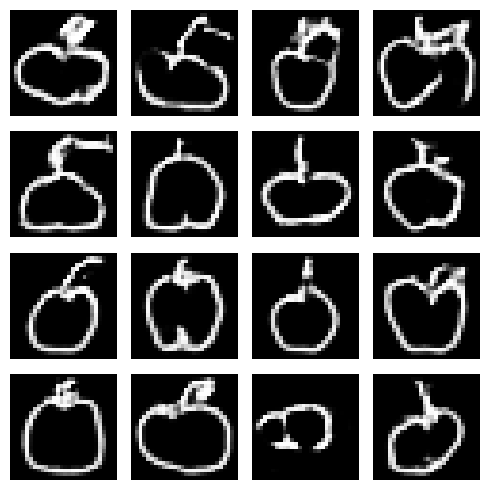

4/4 [==============================] - 0s 14ms/step
Epoch #699
699: [D loss: 0.707492, acc: 0.610996]  [A loss: 1.168685, acc: 0.390044]
1/1 [==============================] - 0s 19ms/step


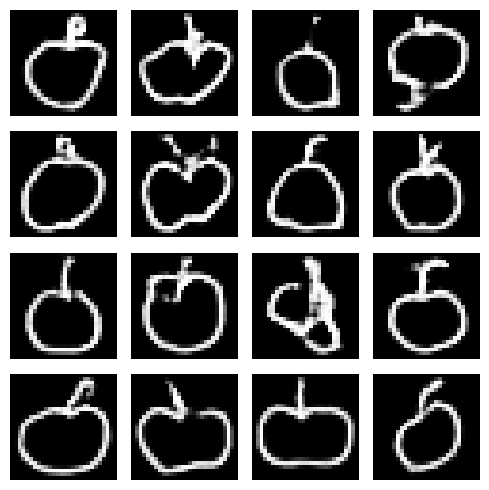

4/4 [==============================] - 0s 14ms/step
Epoch #799
799: [D loss: 0.699860, acc: 0.608886]  [A loss: 1.149270, acc: 0.385159]
1/1 [==============================] - 0s 20ms/step


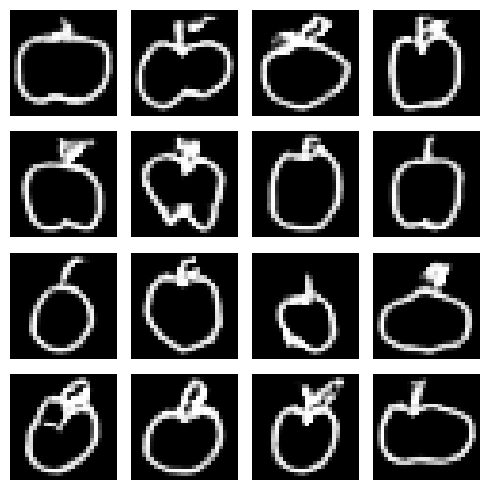

4/4 [==============================] - 0s 15ms/step
Epoch #899
899: [D loss: 0.693023, acc: 0.608341]  [A loss: 1.137850, acc: 0.381283]
1/1 [==============================] - 0s 26ms/step


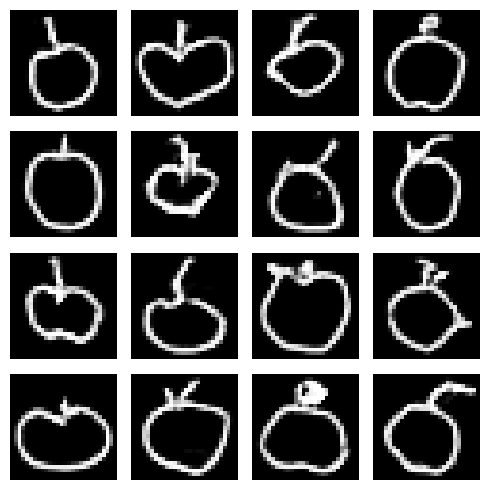

4/4 [==============================] - 0s 19ms/step


KeyboardInterrupt: 

In [25]:
a_metrics_complete, d_metrics_complete = train()

In [26]:
ax = pd.DataFrame(
    {
        "Adversarial": [metric[0] for metric in a_metrics_complete],
        "Discriminator": [metric[0] for metric in d_metrics_complete],
    }
).plot(title="Training Loss", logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

NameError: name 'a_metrics_complete' is not defined

In [27]:
ax = pd.DataFrame(
    {
        "Adversarial": [metric[1] for metric in a_metrics_complete],
        "Discriminator": [metric[1] for metric in d_metrics_complete],
    }
).plot(title="Training Accuracy")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")

NameError: name 'a_metrics_complete' is not defined